# Reproducing experimental results

## 0. General settings

In [1]:
#----------------
# import modules
#----------------
import os
from utils.util import load_dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import numpy as np

In [2]:
#---------------------
# user-defined params 
#---------------------
GPU              = 0
VEHICLE_SPEED    = 41.0 # km/h
WAIT_TIME        = 0.5  # h
TRAIN_BATCH_SIZE = 128
EVAL_BATCH_SIZE  = 128
MAX_BATCH_SIZE   = 128
EVAL_SIZE        = 128
TRAIN_EPOCH      = 0
TRAIN_SAMPLE     = 128
VALID_SAMPLE     = 128
EVAL_SAMPLE      = 128
RL_BASELINE      = "rollout"
RANDOM_SEED      = 1234
TRAIN_PATTERNS   = [
    {
        "name": "ev12_n50_t12",
        "num_evs": 12,
        "num_custms": 50,
        "time_horizon": 12,
        "dropout": 0.2
    },
    {
        "name": "ev12_n25_t12",
        "num_evs": 12,
        "num_custms": 25,
        "time_horizon": 12,
        "dropout": 0.2
    },
    {
        "name": "ev6_n50_t12",
        "num_evs": 6,
        "num_custms": 50,
        "time_horizon": 12,
        "dropout": 0.2
    },
]
#-------------------------
# end user-defined params
#-------------------------


#---------------------------------------------
# the following params are automatically set,
# so DO NOT tatch them
#---------------------------------------------

#-----------
# file name
#-----------
DATASET_DIR     = "data/syn_ev{num_evs}_n{num_custms}"
CHECKPOINT_DIR  = "checkpoints/weight100_ev{num_evs}_n{num_custms}_t{time_horizon}_drop{dropout}"
OUTPUT_DIR      = "results/{dataset_name}_T{time_horizon}_evaluation/{model_name}"

#------------
# model list
#------------
model_list = []
for train_params in TRAIN_PATTERNS:
    num_evs  = train_params["num_evs"]
    num_custms = train_params["num_custms"]
    time_horizon = train_params["time_horizon"]
    dropout = train_params["dropout"]
    model = {
        "dataset_dir": DATASET_DIR.format(num_evs=num_evs, num_custms=num_custms),
        "checkpoint_dir": CHECKPOINT_DIR.format(num_evs=num_evs, num_custms=num_custms, time_horizon=time_horizon, dropout=dropout),
        "train_params": train_params
    }
    model_list.append(model)

## 1. Generating synthetic datasets
It takes around 10 minutes to generate a dataset.

In [3]:
generated_dataset_list = []
for model in model_list:
    dataset_dir = model["dataset_dir"]
    if dataset_dir not in generated_dataset_list: # avoid duplicating the same dataset
        num_evs  = train_params["num_evs"]
        num_custms = train_params["num_custms"]
        !python generate_dataset.py --save_dir {dataset_dir} \
                                    --num_samples {TRAIN_SAMPLE} {VALID_SAMPLE} {EVAL_SAMPLE} \
                                    --num_vehicles {num_evs} \
                                    --num_custms {num_custms} \
                                    --random_seed {RANDOM_SEED}
    generated_dataset_list.append(dataset_dir)

100%|███████████████████████████████████████| 384/384 [00:00<00:00, 6460.75it/s]
saving a dataset to data/syn_ev12_n50/train_dataset.pkl...done
saving a dataset to data/syn_ev12_n50/valid_dataset.pkl...done
saving a dataset to data/syn_ev12_n50/eval_dataset.pkl...done
100%|███████████████████████████████████████| 384/384 [00:00<00:00, 6613.61it/s]
saving a dataset to data/syn_ev12_n25/train_dataset.pkl...done
saving a dataset to data/syn_ev12_n25/valid_dataset.pkl...done
saving a dataset to data/syn_ev12_n25/eval_dataset.pkl...done
100%|███████████████████████████████████████| 384/384 [00:00<00:00, 6605.91it/s]
saving a dataset to data/syn_ev6_n50/train_dataset.pkl...done
saving a dataset to data/syn_ev6_n50/valid_dataset.pkl...done
saving a dataset to data/syn_ev6_n50/eval_dataset.pkl...done


## 2. Training models
A single RTX A6000 takes about 10 days to train a model for 100 epochs.  
Therefore, we recommend training models in parallel via the terminal, not this notebook.

In [4]:
def main(args):
# 在检查目录存在时自动处理
    if os.path.exists(args.checkpoint_dir):
        shutil.rmtree(args.checkpoint_dir)  # 直接删除旧目录
    os.makedirs(args.checkpoint_dir)

In [ ]:
for model in model_list:
    dataset_path    = model["dataset_dir"] + "/train_dataset.pkl"
    checkpoint_dir  = model["checkpoint_dir"]
    num_evs         = model["train_params"]["num_evs"]
    num_custms      = model["train_params"]["num_custms"]
    time_horizon    = model["train_params"]["time_horizon"]
    dropout         = model["train_params"]["dropout"]
    # train
    !yes y |python train.py --dataset_path {dataset_path} \
                     --checkpoint_dir {checkpoint_dir} \
                     --time_horizon {time_horizon} \
                     --batch_size {TRAIN_BATCH_SIZE} \
                     --baseline {RL_BASELINE} \
                     --vehicle_speed {VEHICLE_SPEED} \
                     --wait_time {WAIT_TIME} \
                     --epoch {TRAIN_EPOCH} \
                     --dropout {dropout} \
                     --gpu 1\

selected device: CPU
100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]
Epoch 0: saving a model to checkpoints/weight100_ev12_n50_t12_drop0.2/model_epoch0.pth...done.
100%|██████████████████████████████████| 1/1 [00:14<00:00, 14.24s/it, cost=35.6]
evaluating current policy on evaluation dataset
100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]
Epoch 0 candidate mean 35.945308685302734, baseline epoch 0 mean 36.517417907714844, difference -0.5721092224121094
p-value: 1.1050317850839152e-62
Update baseline
100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]
yes: stdout: Broken pipe
selected device: CPU
100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]
Epoch 0: saving a model to checkpoints/weight100_ev12_n25_t12_drop0.2/model_epoch0.pth...done.
100%|██████████████████████████████████| 1/1 [00:15<00:00, 15.08s/it, cost=35.6]
evaluating current policy on evaluation datas

-1-》 -1。 and #1 change path from “--model_checkpoint_path”

## 3. Hold-out Validation (Model selection)

In [ ]:
for model in model_list:
    dataset_path = model["dataset_dir"] + "/valid_dataset.pkl"
    model_dir    = model["checkpoint_dir"]
    time_horizon = model["train_params"]["time_horizon"]
    # validate
    !python valid.py --model_dir {model_dir} \
                     --dataset_path {dataset_path} \
                     --eval_batch_size {EVAL_BATCH_SIZE} \
                     --vehicle_speed {VEHICLE_SPEED} \
                     --wait_time {WAIT_TIME} \
                     --time_horizon {time_horizon} \
                     --max_epoch {TRAIN_EPOCH} \
                     --gpu 1

Evaluating the model at epoch0 (currently best epoch is 0: cost=1000000000.0)
selected device: CPU
100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.01s/it]
Evaluating the model at epoch0 (currently best epoch is 0: cost=1000000000.0)
selected device: CPU
100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.69s/it]
Evaluating the model at epoch0 (currently best epoch is 0: cost=1000000000.0)
selected device: CPU
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.63s/it]


## 4. Quantitative evaluation

### 4.0. General Settings

In [ ]:
competiter_list = [
    {
        "name": "wo_move",
        "model_type": "wo_move",
        "decode_type": None,
        "search_width": 1,
    },
    {
        "name": "greedy",
        "model_type": "naive_greedy",
        "decode_type": None,
        "search_width": 1,
    },
    {
        "name": "random",
        "model_type": "naive_random",
        "decode_type": None,
        "search_width": 1280,
    },
    {
        "name": "rlgreedy",
        "model_type": "rl",
        "decode_type": "greedy",
        "search_width": 1,
    },
    {
        "name": "rlsample1280",
        "model_type": "rl",
        "decode_type": "sampling",
        "search_width": 128,
    },
    {
        "name": "rlsample12800",
        "model_type": "rl",
        "decode_type": "sampling",
        "search_width": 128,
    },
]

# change name rl->tsn1 rl1280->tsn2

In [ ]:
import pandas as pd
import json
from typing import List, Dict, Any
from eval import eval

#---------------------
# evaluate all models
#---------------------
def eval_all(competiter_list: List[Dict[str, Any]],
             dataset_list: List[Dict[str, str]],
             timehorizon_list: List[int],
             visualize_routes: bool = False) -> None:
    for dataset_name, dataset_path, model_dir in dataset_list:
        for time_horizon in timehorizon_list:
            print(f"{dataset_name} T={time_horizon}")
            for competiter in competiter_list:
                
                print(competiter["model_type"], competiter["decode_type"], competiter["search_width"])
                output_dir = OUTPUT_DIR.format(dataset_name=dataset_name, time_horizon=time_horizon, model_name=competiter["name"])
                # evaluate
                eval(time_horizon=time_horizon,
                     model_type=competiter["model_type"],
                     decode_type=competiter["decode_type"],
                     search_width=competiter["search_width"],
                     dataset_path=dataset_path,
                     model_dir=model_dir,
                     output_dir=output_dir,
                     gpu=1,
                     vehicle_speed=VEHICLE_SPEED,
                     wait_time=WAIT_TIME,
                     max_batch_size=MAX_BATCH_SIZE,
                     eval_batch_size=EVAL_BATCH_SIZE,
                     max_load_size=EVAL_SIZE,
                     visualize_routes=visualize_routes)

#----------------------------------
# summarize the evaluation results
#----------------------------------
def summarize_results(competiter_list: List[Dict[str, Any]],
                      dataset_list: List[Dict[str, str]],
                      timehorizon_list: List[int]) -> pd.DataFrame:
    idx = []; col1 = []; col2 = []; results = [[] for _ in range(len(competiter_list))]
    for i, competiter in enumerate(competiter_list):
        model_name = competiter["name"]
        idx.append(model_name)
        for dataset_name, dataset_path, model_dir in dataset_list:
            for time_horizon in timehorizon_list:
                if i == 0:
                    for eval_values in ["len.", "down", "obj", "time"]:
                        col1.append(f"{dataset_name}_T{time_horizon}")
                        col2.append(eval_values)
                # read a log file
                log_fname = OUTPUT_DIR.format(dataset_name=dataset_name, time_horizon=time_horizon, model_name=model_name) + "/summary.json"
                with open(log_fname, "r") as f:
                    res = json.load(f)
                    results[i].append(round(float(res["avg_actual_tour_length"]))) # (actual) route length
                    results[i].append(round(float(res["avg_num_down"]), 2))        # num down custms
                    results[i].append(round(float(res["avg_obj"]), 2))             # objevtive value
                    results[i].append(round(float(res["total_calc_time"]), 2))     # total calc time
    col = pd.MultiIndex.from_arrays([col1, col2])
    return pd.DataFrame(results, index=idx, columns=col)

### 4.1. Evaluation on synthetic datasets

In [14]:
syn_dataset_list = [
    ("SYN-EV6", "data/syn_ev6_n50/eval_dataset.pkl",   "checkpoints/weight100_ev6_n50_t12_drop0.2"),
    ("SYN-EV12", "data/syn_ev12_n50/eval_dataset.pkl", "checkpoints/weight100_ev12_n50_t12_drop0.2")
]
timehorizon_list = [12, 24]

In [15]:
vis = True  # 或者 False，根据需要选择是否启用可视化

In [16]:
eval_all(competiter_list, syn_dataset_list, timehorizon_list, vis)

SYN-EV6 T=12
wo_move None 1
selected device: CPU


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


naive_greedy None 1
selected device: CPU


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


naive_random None 1280
selected device: CPU


  0%|          | 0/1 [02:49<?, ?it/s]


AssertionError: 

In [ ]:
summarize_results(competiter_list, syn_dataset_list, timehorizon_list)

SYN-EV6_T12                       SYN-EV6_T24                \
                     len.   down    obj    time        len.   down    obj   
wo_move                 0  21.29  42.59    0.09           0  34.45  68.89   
greedy                213  19.14  40.41    0.03         370  30.59  64.87   
random                155  16.63  34.82   11.77         304  27.10  57.24   
rlgreedy              211  17.26  36.63    0.04         357  29.67  62.91   
rlsample1280          133  16.89  35.10   11.82         297  27.73  58.42   
rlsample12800         167  16.31  34.30  127.41         272  27.27  57.26   

                      SYN-EV12_T12                       SYN-EV12_T24         \
                 time         len.   down    obj    time         len.   down   
wo_move          0.19            0  21.29  42.59    0.10            0  34.45   
greedy           0.06          213  19.14  40.41    0.03          370  30.59   
random          24.46          155  16.63  34.82   13.37          304  27.10   
rlgreedy         0.10          211  17.26  36.63    0.04          357  29.67   
rlsample1280    24.03          133  16.89  35.10   13.91          297  27.73   
rlsample12800  237.73          167  16.31  34.30  141.25          272  27.27   

                              
                 obj    time  
wo_move        68.89    0.22  
greedy         64.87    0.06  
random         57.24   27.15  
rlgreedy       62.91    0.10  
rlsample1280   58.42   24.93  
rlsample12800  57.26  244.69

### 4.2. Evaluation on SYN datasets (only private)
As we use our private dataset, you cannot conduct the experiments below.  
Please see the results just for reference purposes.

In [ ]:
SYN_dataset_list = [
    ("SYN-EV6",  "data/SYN_datasets/SYN_ev6.pkl",   "checkpoints/weight100_ev6_n50_t12_drop0.2"),
    ("SYN-EV12",  "data/SYN_datasets/SYN_ev12.pkl",   "checkpoints/weight100_ev12_n50_t12_drop0.2"),
]
timehorizon_list = [12, 24]

In [ ]:
#eval_all(competiter_list, SYN_dataset_list, timehorizon_list, visualize_routes=True)

In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
print(f"veh_init_position_id length: {len(self.veh_init_position_id)}")
print(f"veh_id: {veh_id}")


NameError: name 'self' is not defined

In [ ]:
#-----------------
# evaluate CP4TSN
#-----------------
dt_list = [
    ("tsn1",  1.0, None, None),
    ("tsn05", 0.5, None, None)
]
for dataset_name, dataset_path, _ in syn_dataset_list:
    for time_horizon in timehorizon_list:
        print(f"{dataset_name} T={time_horizon}")
        for model_name, dt, _, __ in dt_list:
            print(model_name)
            output_dir = f"results/{dataset_name}_T{time_horizon}_evaluation/{model_name}"
            log_fname  = f"{output_dir}/summary.json"
            !python eval_cp4tsn.py --dataset_path {dataset_path} \
                                   --clustering \
                                   --cluster_type kmeans \
                                   --merge_duplicated_depots \
                                   --time_horizon {time_horizon} \
                                   --parallel \
                                   --num_cpus 4 \
                                   --limit_type time \
                                   --time_limit  180 \  
                                   --dt {dt} \
                                   --log_fname {log_fname}

In [ ]:
#change time limit from 1800 to 180

In [ ]:
tsn_list = [
    {
        "name": "tsn1",
        "model_type": 1.0,
        "decode_type": None,
        "search_width": None,
    },
    {
        "name": "tsn05",
        "model_type": 0.5,
        "decode_type": None,
        "search_width": None,
    },
]

all_competiter_list = competiter_list + tsn_list

In [ ]:
summarize_results(all_competiter_list, SYN_dataset_list, timehorizon_list)

NameError: name 'all_competiter_list' is not defined

## 5. Visualization of routes

In [ ]:
def get_color(id):
    cmap = plt.get_cmap("tab10")
    additional_colors = ["gold", "chartreuse"]
    if id <= 9:
        color = cmap(id)
    else:
        color = additional_colors[id - 10]
    return color

class BSColor():
    def __init__(self):
        self.idx_list = [0, 0, 0, 0]
    
    def get_color(self, init_batt):
        reds    = ["red", "salmon", "brown", "orangered"]
        greens  = ["gold", "orange", "goldenrod", "darkkhaki"]
        blues   = ["forestgreen", "limegreen", "darkgreen", "green", "lime", "seagreen", "mediumseagreen", "springgreen", 
                   "mediumspringgreen", "mediumaquamarine", "aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "palegreen",
                   "lightgreen", "yellowgreen", "darkolivegreen", "greenyellow", "chartreuse", "lawngreen", "olive", "darkseagreen"]
        purples = ["purple", "midnightblue", "navy", "darkblue", "mediumblue", "blue", "slateblue", "darkslateblue", "mediumslateblue", "mediumpurple",
                   "steelblue", "cornflowerblue", "royalblue", "rebeccapurple", "blueviolet", "indigo", "darkorchid", "darkviolet", "mediumorchid", "plum", "violet", "darkmagenta"]
        
        if init_batt < 5.0:
            color = reds[self.idx_list[0]] if self.idx_list[0] < len(reds) else reds[0]
            self.idx_list[0] += 1
            return color, 3, 1
        elif init_batt >= 5.0 and init_batt <= 10:
            color = greens[self.idx_list[1]] if self.idx_list[1] < len(greens) else greens[0]
            self.idx_list[1] += 1
            return color, 2, 0.8
        elif init_batt >= 25 and init_batt <= 30: 
            color = blues[self.idx_list[2]] if self.idx_list[2] < len(blues) else blues[0]
            self.idx_list[2] += 1
            return color, 1, 0.6
        else:
            color = purples[self.idx_list[3]] if self.idx_list[3] < len(purples) else purples[0]
            self.idx_list[3] += 1
            return color, 0, 0.2


def visualize_route(ax, route_data):
    # add base stations & charge stations
    markersize = 8
    custm_coords = np.array(route_data["custm_coords"])
    dep_coords = np.array(route_data["depot_coords"])
    ignored_depots = np.array(route_data["ignored_depots"])
    x_custm = custm_coords[:, 0]; y_custm = custm_coords[:, 1]
    x_dep = dep_coords[:, 0]; y_dep = dep_coords[:, 1]
    ax.scatter(x_custm, y_custm, zorder=2, s=markersize, c="black", label="Base stations") # base stations
    ax.scatter(x_dep[~ignored_depots], y_dep[~ignored_depots], marker="s", zorder=2, s=markersize, c="none", ec="red", label="Charge stations") # charge stations
    
    # add routes
    routes = route_data["route"]
    coords = np.concatenate([custm_coords, dep_coords], axis=0)
    x_coo = coords[:, 0]; y_coo = coords[:, 1]
    num_vehicles = len(routes)
    for veh_id, route in enumerate(routes):
        color = get_color(veh_id)
        for i in range(len(route)-1):
            curr_id = route[i]
            next_id = route[i+1]
            st = coords[curr_id]
            end = coords[next_id]
            ax.annotate('', xy=end, xytext=st,
                        arrowprops=dict(shrink=0, width=0.5, headwidth=3, 
                        headlength=4, connectionstyle='arc3',
                        facecolor=color, edgecolor='none', alpha=0.5), zorder=1)
    ax.set_xticks([]); ax.set_yticks([])

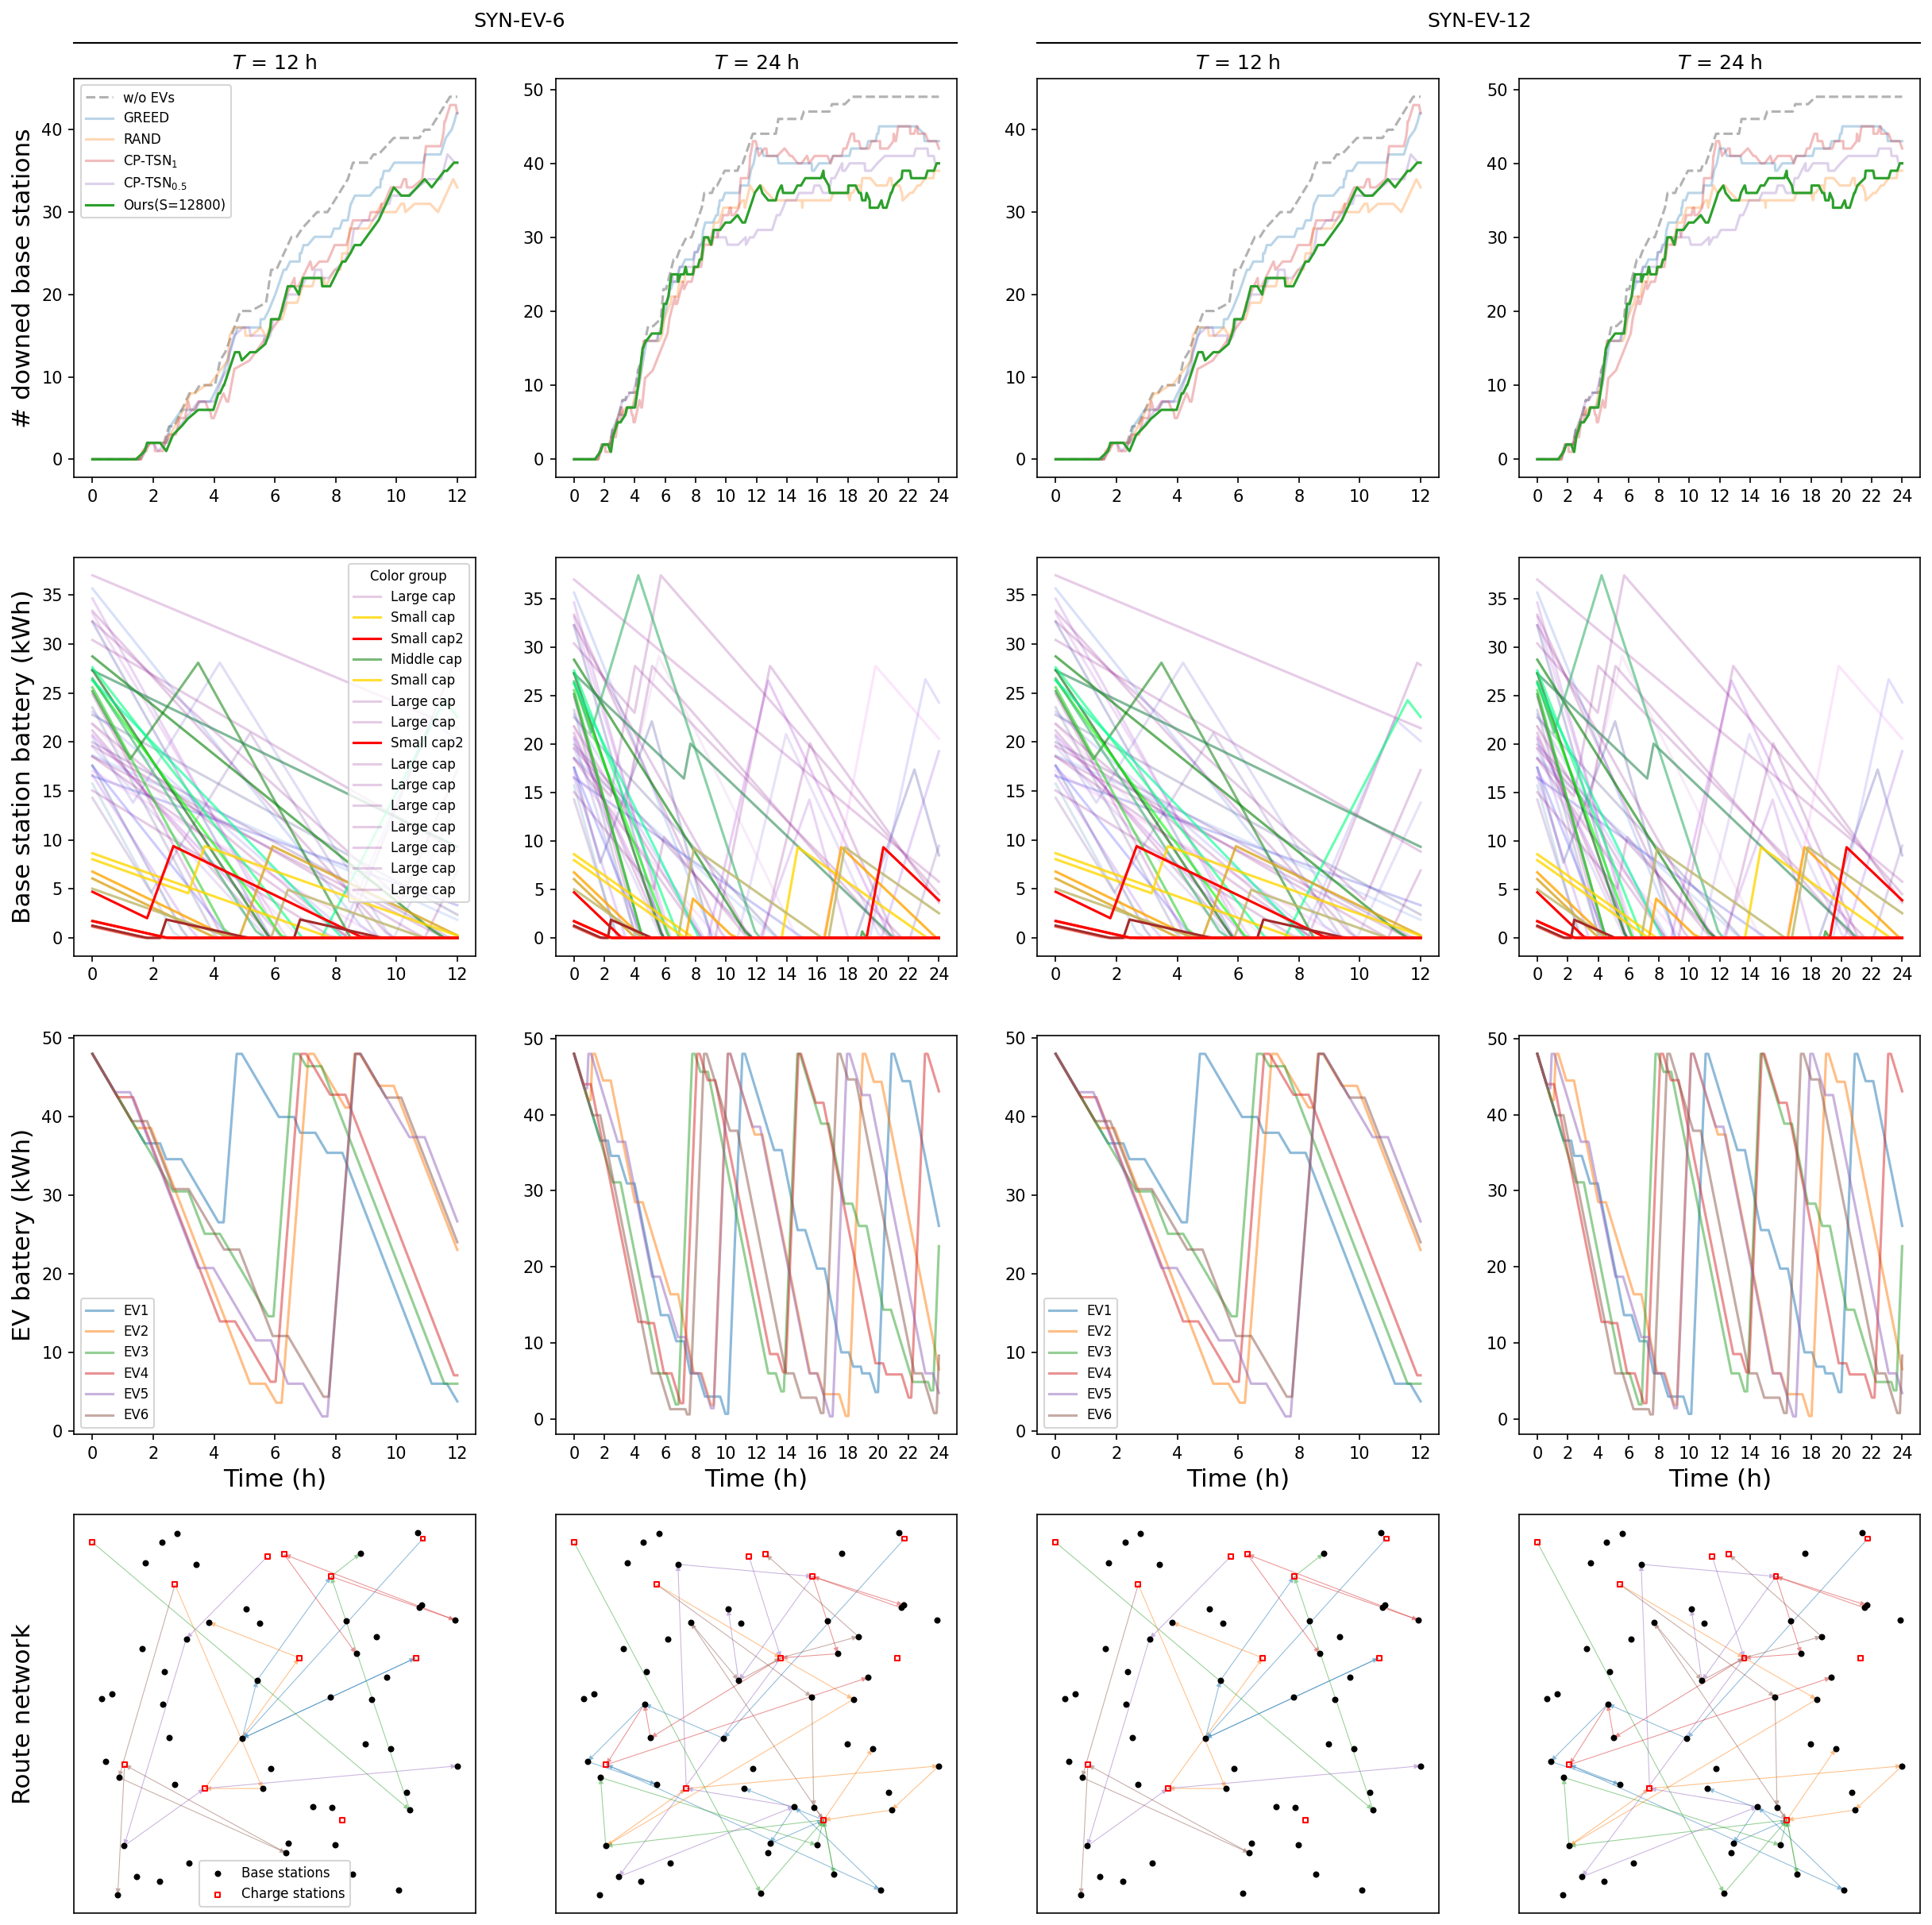

In [ ]:
import pickle
from matplotlib.lines import Line2D
cmap = plt.get_cmap("tab10")

#------------------
# visual paramters
#------------------
DPI = 150
FONT_SIZE = 15
ALPHA = 0.3

vis_dataset_list = [
    ("SYN-EV6",  "data/SYN_datasets/SYN_ev6.pkl",   "checkpoints/weight100_ev6_n50_t12_drop0.2"),
    ("SYN-EV12",  "data/SYN_datasets/SYN_ev12.pkl",   "checkpoints/weight100_ev12_n50_t12_drop0.2"),
]
vis_timehorizon_list = [12, 24]
vis_model_list = [
    {
        "name": "wo_move",
        "label": "w/o EVs",
        "color": "black",
        "linestyle": "--"
    },
    {
        "name": "greedy",
        "label": "GREED",
        "color": cmap(0),
        "linestyle": "-"
    },
    {
        "name": "random",
        "label": "RAND",
        "color": cmap(1),
        "linestyle": "-"
    },
    {
        "name": "tsn1", #rlgreedy
        "label": "CP-TSN$_1$",
        "color": cmap(3),
        "linestyle": "-"
    },
    {
        "name": "tsn05", # rlsample1280
        "label": "CP-TSN$_{0.5}$",
        "color": cmap(4),
        "linestyle": "-"
    },
    {
        "name": "rlsample12800", 
        "label": "Ours(S=12800)",
        "color": cmap(2),
        "linestyle": "-"
    },
]
output_route_model = "rlsample12800"
legend_color = {
    "red": "Small cap2", 
    "gold": "Small cap",
    "forestgreen": "Middle cap", 
    "purple": "Large cap"
}

#---------------
# visualization
#---------------
fig = plt.figure(figsize=(20, 20), dpi=DPI)
ax_dict = {}
for j, (dataset_name, dataset_path, _) in enumerate(vis_dataset_list):
    for i, time_horizon in enumerate(vis_timehorizon_list):
        prefix = f"{dataset_name}_T{time_horizon}"
        ev_batt_key    = f"{prefix}_ev_batt_hist"
        custm_batt_key   = f"{prefix}_custm_batt_hist"
        down_hist_key  = f"{prefix}_down_hist"
        route_key      = f"{prefix}_route"
        ax_dict[down_hist_key]  = fig.add_subplot(4, 4, 2*j + i + 1) # history of num. of downed base stations
        ax_dict[custm_batt_key]   = fig.add_subplot(4, 4, 2*j + i + 5) # history of Base station's battery
        ax_dict[ev_batt_key]    = fig.add_subplot(4, 4, 2*j + i + 9) # history of EV's battery
        ax_dict[route_key]      = fig.add_subplot(4, 4, 2*j + i + 13) # route

        for vis_model in vis_model_list:
            model_name = vis_model["name"]
            # load data
            res_dir = f"results/{dataset_name}_T{time_horizon}_evaluation/{model_name}/batch0-sample0"
            history_file = f"{res_dir}/history_data.pkl"

            # History of # of downed base stations
            with open(history_file, "rb") as f:
                history_data = pickle.load(f)
                alpha = 1 if model_name == output_route_model else ALPHA
                ax_dict[down_hist_key].plot(history_data["time"], history_data["down_custm"], c=vis_model["color"], label=vis_model["label"], linestyle=vis_model["linestyle"], alpha=alpha)
                ax_dict[down_hist_key].set_title(f"$T$ = {time_horizon} h")
                if i + j == 0: # The y-axis label and the legent are only present in the left-most figure.
                    ax_dict[down_hist_key].set_ylabel("# downed base stations", fontsize=FONT_SIZE)
                    ax_dict[down_hist_key].legend(fontsize=8)
                if time_horizon == 24:
                    ax_dict[down_hist_key].set_xticks(np.arange(0, 25, 2))

            if model_name == output_route_model:
                # Route visualization
                route_file = f"{res_dir}/route_info.pkl"
                with open(route_file, "rb") as f:
                    route_data = pickle.load(f)
                    visualize_route(ax_dict[route_key], route_data)
                    if i + j == 0: # The y-axis label is only present in the left-most figure.
                        ax_dict[route_key].set_ylabel("Route network", fontsize=FONT_SIZE)
                        ax_dict[route_key].legend(fontsize=8)
                        
                # Battery History
                with open(history_file, "rb") as f:
                    history_data = pickle.load(f)
                    # EV battery
                    cmap = plt.get_cmap("tab10")
                    for veh_id in range(len(history_data["veh_batt"])):
                        ax_dict[ev_batt_key].plot(history_data["time"], history_data["veh_batt"][veh_id], label=f"EV{veh_id+1}", color=get_color(veh_id), alpha=0.5)
                        ax_dict[ev_batt_key].set_xlabel("Time (h)", fontsize=FONT_SIZE)
                        if i + j == 0: # The y-axis label is only present in the left-most figure.
                            ax_dict[ev_batt_key].set_ylabel("EV battery (kWh)", fontsize=FONT_SIZE)
                            ax_dict[ev_batt_key].legend(fontsize=8)
                        if 2*j + i + 9 == 11:
                            ax_dict[ev_batt_key].legend(fontsize=8)
                        if time_horizon == 24:
                            ax_dict[ev_batt_key].set_xticks(np.arange(0, 25, 2))
                            
                    # Base station battery
                    bs_color = BSColor() 
                    for custm_id in range(len(history_data["custm_batt"])):
                        init_batt = history_data["custm_batt"][custm_id][0]
                        color, zorder, alpha = bs_color.get_color(init_batt)
                        label = None if color not in list(legend_color.keys()) else legend_color[color] 
                        ax_dict[custm_batt_key].plot(history_data["time"], history_data["custm_batt"][custm_id], alpha=alpha, color=color, zorder=zorder, label=label)
                        if i + j == 0: # The y-axis label is only present in the left-most figure.
                            ax_dict[custm_batt_key].set_ylabel("Base station battery (kWh)", fontsize=FONT_SIZE)
                            ax_dict[custm_batt_key].legend(title="Color group", title_fontsize=8, fontsize=8)
                        if time_horizon == 24:
                            ax_dict[custm_batt_key].set_xticks(np.arange(0, 25, 2))

# title setting
Y_OFFSET = 0.015
fig.text(0.312, 0.9, 'SYN-EV-6', ha='center', va='bottom', fontsize=12)
fig.text(0.715, 0.9, 'SYN-EV-12', ha='center', va='bottom', fontsize=12)
left_ax  = ax_dict["SYN-EV6_T12_down_hist"].get_position()
right_ax = ax_dict["SYN-EV6_T24_down_hist"].get_position()
fig.add_artist(Line2D([left_ax.x0, right_ax.x1], [left_ax.y1 + Y_OFFSET, left_ax.y1 + Y_OFFSET], color="black", transform=fig.transFigure, linewidth=1))
left_ax  = ax_dict["SYN-EV12_T12_down_hist"].get_position()
right_ax = ax_dict["SYN-EV12_T24_down_hist"].get_position()
fig.add_artist(Line2D([left_ax.x0, right_ax.x1], [left_ax.y1 + Y_OFFSET, left_ax.y1 + Y_OFFSET], color="black", transform=fig.transFigure, linewidth=1))
fig.align_labels([ax for ax in ax_dict.values()])

## 6. Computational Scalability Test & Generalization Test

In [ ]:
RANDOM_SEED = 0
NUM_SAMPLES = 100
GPU = 1
time_horizon_list = [12, 24, 36, 48]
num_custm_list      = [25, 50, 75, 100]
num_ev_list       = [6, 12, 18, 24]



### 6.1. Generating new evaluation datasets for scalability & generalization tests 

In [ ]:
# for time horizon
!python generate_dataset.py --num_custms 25 \
                            --num_vehicles 12 \
                            --save_dir data/gen_scale_test/test_time_horizon \
                            --type eval \
                            --num_samples {NUM_SAMPLES} \
                            --random_seed {RANDOM_SEED}

# for num_custms
for num_custms in num_custm_list:
    !python generate_dataset.py --num_custms {num_custms} \
                                --num_vehicles 12 \
                                --save_dir data/gen_scale_test/test_num_nodes{num_custms} \
                                --type eval \
                                --num_samples {NUM_SAMPLES} \
                                --random_seed {RANDOM_SEED}

# for num_evs
for num_evs in num_ev_list:
    !python generate_dataset.py --num_custms 50 \
                                --num_depots {num_evs} \
                                --num_vehicles {num_evs} \
                                --save_dir data/gen_scale_test/test_num_evs{num_evs} \
                                --type eval \
                                --num_samples {NUM_SAMPLES} \
                                --random_seed {RANDOM_SEED}

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7080.67it/s]
saving a dataset to data/gen_scale_test/test_time_horizon/eval_dataset.pkl...done
100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7949.03it/s]
saving a dataset to data/gen_scale_test/test_num_nodes25/eval_dataset.pkl...done
100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6401.27it/s]
saving a dataset to data/gen_scale_test/test_num_nodes50/eval_dataset.pkl...done
100%|███████████████████████████████████████| 100/100 [00:00<00:00, 5401.69it/s]
saving a dataset to data/gen_scale_test/test_num_nodes75/eval_dataset.pkl...done
100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4624.57it/s]
saving a dataset to data/gen_scale_test/test_num_nodes100/eval_dataset.pkl...done
100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6428.45it/s]
saving a dataset to data/gen_scale_test/test_num_evs6/eval_dataset.pkl...done
100%|████████████████████████

### 6.2. Evaluation (objective value and calculation time)

In [ ]:
from typing import Union
import subprocess

def call_eval(model_dir: str,
              model_type: str,
              dataset_path: str,
              time_horizon: float,
              decode_type: Union[str, float],
              search_width: int,
              output_dir: str) -> None:
    if model_type == "cp4tsn":
        # evaluate CP4TSN
        command = f"python eval_cp4tsn.py --dataset_path {dataset_path} " \
                  f"--time_horizon {time_horizon} --clustering " \
                  f"--cluster_type kmeans --parallel --num_cpus 24 " \
                  f"--limit_type time --time_limit {search_width} " \
                  f"--dt {decode_type} --log_fname {output_dir}/log.txt"
        subprocess.run(command, shell=True)
    else:    
        # evaluate naive & RL models
        eval(time_horizon=time_horizon,
             model_type=model_type,
             decode_type=decode_type,
             search_width=search_width,
             dataset_path=dataset_path,
             model_dir=model_dir,
             output_dir=output_dir,
             gpu=1,
             vehicle_speed=VEHICLE_SPEED,
             wait_time=WAIT_TIME,
             max_batch_size=MAX_BATCH_SIZE,
             eval_batch_size=1)

In [ ]:
# we use the weights trained on SYN-EV-6S (num_evs=6, num_custms=25, T=12)
cmap = plt.get_cmap("tab10")
eval_model_list = [
    # we do not evaluate tsn here because "IndexError: list index out of range" occurs, and that is impracticable
    # {
    #     "name": "tsn1",
    #     "label": "CP-TSN$_1$",
    #     "model_type": "cp4tsn",
    #     "decode_type": 1.0, # dt
    #     "color": cmap(3),
    #     "marker": "^",
    #     "search_width": 1800, # time limit (s)
    # },
    # {
    #     "name": "tsn05",
    #     "label": "CP-TSN$_{0.5}$",
    #     "model_type": "cp4tsn",
    #     "decode_type": 0.5, # dt
    #     "color": cmap(4),
    #     "marker": "x",
    #     "search_width": 1800, # time limit (s)
    # },
    {
        "name": "greedy",
        "label": "GREED",
        "model_type": "naive_greedy",
        "decode_type": None,
        "color": cmap(0),
        "marker": "d",
        "search_width": 1,
    },
    {
        "name": "random",
        "label": "RAND",
        "color": cmap(1),
        "marker": "p",
        "model_type": "naive_random",
        "decode_type": None,
        "search_width": 128,
    },
    {
        "name": "rlgreedy",
        "label": "Ours (G)", 
        "model_type": "rl",
        "color": cmap(5),
        "marker": "o",
        "decode_type": "greedy",
        "search_width": 1,
    },
    {
        "name": "rlsample1280",
        "label": "Ours (S=1280)",
        "model_type": "rl",
        "color": cmap(6),
        "marker": "s",
        "decode_type": "sampling",
        "search_width": 128, 
    },
    {
        "name": "rlsample12800",
        "label": "Ours (S=12800)",
        "model_type": "rl",
        "color": cmap(2),
        "marker": "*",
        "decode_type": "sampling",
        "search_width": 128,
    },
]

In [ ]:
# for time horizon
MODEL_DIR = "checkpoints/weight100_ev12_n25_t12_drop0.2"
dataset_path = "data/gen_scale_test/test_time_horizon/eval_dataset.pkl"
for eval_model in eval_model_list:
    for time_horizon in time_horizon_list:
        print(f"T = {time_horizon}")
        output_dir = f"results/test_time_horizon/{eval_model['name']}_time_horizon{time_horizon}"
        call_eval(model_dir=MODEL_DIR,
                  dataset_path=dataset_path,
                  time_horizon=time_horizon,
                  model_type=eval_model["model_type"],
                  decode_type=eval_model["decode_type"],
                  search_width=eval_model["search_width"],
                  output_dir=output_dir)

# for num_custms
MODEL_DIR = "checkpoints/weight100_ev12_n25_t12_drop0.2"
for eval_model in eval_model_list:
    for num_custms in num_custm_list:
        print(f"num_custms = {num_custms}")
        dataset_path = f"data/gen_scale_test/test_num_nodes{num_custms}/eval_dataset.pkl"
        output_dir = f"results/test_num_custms/{eval_model['name']}_num_custms{num_custms}"
        call_eval(model_dir=MODEL_DIR,
                  dataset_path=dataset_path,
                  time_horizon=12,
                  model_type=eval_model["model_type"],
                  decode_type=eval_model["decode_type"],
                  search_width=eval_model["search_width"],
                  output_dir=output_dir)
        
# for num_evs
MODEL_DIR = "checkpoints/weight100_ev6_n50_t12_drop0.2"
for eval_model in eval_model_list:
    for num_evs in num_ev_list:
        print(f"num_evs = {num_evs}")
        dataset_path = f"data/gen_scale_test/test_num_evs{num_evs}/eval_dataset.pkl"
        output_dir = f"results/test_num_evs/{eval_model['name']}_num_evs{num_evs}"
        call_eval(model_dir=MODEL_DIR,
                  dataset_path=dataset_path,
                  time_horizon=12,
                  model_type=eval_model["model_type"],
                  decode_type=eval_model["decode_type"],
                  search_width=eval_model["search_width"],
                  output_dir=output_dir)

T = 12
selected device: CPU


  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Broken pipe

### 6.3. Plotting thr results of scalability & generalization tests

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
markersize = 8
capsize = 5

def plot_scale_gen_res(model_list,
                       ax_dict: Dict[str, matplotlib.axes.Axes],
                       lst: List[int],
                       get_log_fname,
                       xlabel: str = None,
                       ylabel_scale: str = None,
                       ylabel_gen: str = None) -> dict:
    res = {"obj": {}, "time": {}, "obj_std": {}, "time_std": {}}
    for id, model in enumerate(model_list):
        model_name = model["name"]
        res["obj"][model_name] = []
        res["time"][model_name] = []
        res["obj_std"][model_name] = []
        res["time_std"][model_name] = []
        for elem in lst:
            log_fname = get_log_fname(model_name, elem)
            with open(log_fname, "r") as f:
                res_ = json.load(f)
            res["obj"][model_name].append(float(res_["avg_obj"]))        # objevtive value
            res["time"][model_name].append(float(res_["avg_calc_time"])) # averaged calc time per one sample
            res["obj_std"][model_name].append(float(res_["std_obj"]))        # std of objevtive values
            res["time_std"][model_name].append(float(res_["std_calc_time"])) # std of averaged calc time per one sample
    
        def vis_graph(ax_dict_: Dict[str, matplotlib.axes.Axes],
                      key: str,
                      xlabel: str = None,
                      ylabel: str = None) -> None:
            # ax_timehorizon[key].errorbar(time_horizon_list,
            #                              timehorizon_res[key][model_name],
            #                              timehorizon_res[f"{key}_std"][model_name],
            #                              label=label,
            #                              marker=marker,
            #                              markersize=markersize,
            #                              capsize=capsize)
            x = np.array(lst)
            y = np.array(res[key][model_name])
            std = np.array(res[f"{key}_std"][model_name])
            ax_dict_[key].plot(x,
                               y,
                               label=model["label"],
                               marker=model["marker"],
                               markersize=markersize,
                               color=model["color"])
            ax_dict_[key].fill_between(lst, y-std, y+std, alpha=0.2, color=model["color"])
            if key == "time":
                # aux. line
                ax_dict_[key].plot(x, (y[0]/x[0])*x, linestyle="--", color=model["color"], alpha=0.5)
            if xlabel is not None:
                ax_dict_[key].set_xlabel(xlabel, fontsize=20)
            if ylabel is not None:
                ax_dict_[key].set_ylabel(ylabel, fontsize=20)
            ax_dict_[key].set_xticks(lst)
            ax_dict_[key].xaxis.set_tick_params(labelsize=18)
            ax_dict_[key].yaxis.set_tick_params(labelsize=18)
    
        # scalability
        if model_name in ["rlgreedy", "rlsample1280", "rlsample12800"]:
            vis_graph(ax_dict, "time", ylabel=ylabel_scale)
        # generalization
        if model_name in ["greedy", "random", "rlsample12800"]:
            vis_graph(ax_dict, "obj", xlabel, ylabel_gen)
    return res

FileNotFoundError: [Errno 2] No such file or directory: 'results/test_time_horizon/random_time_horizon12/summary.json'

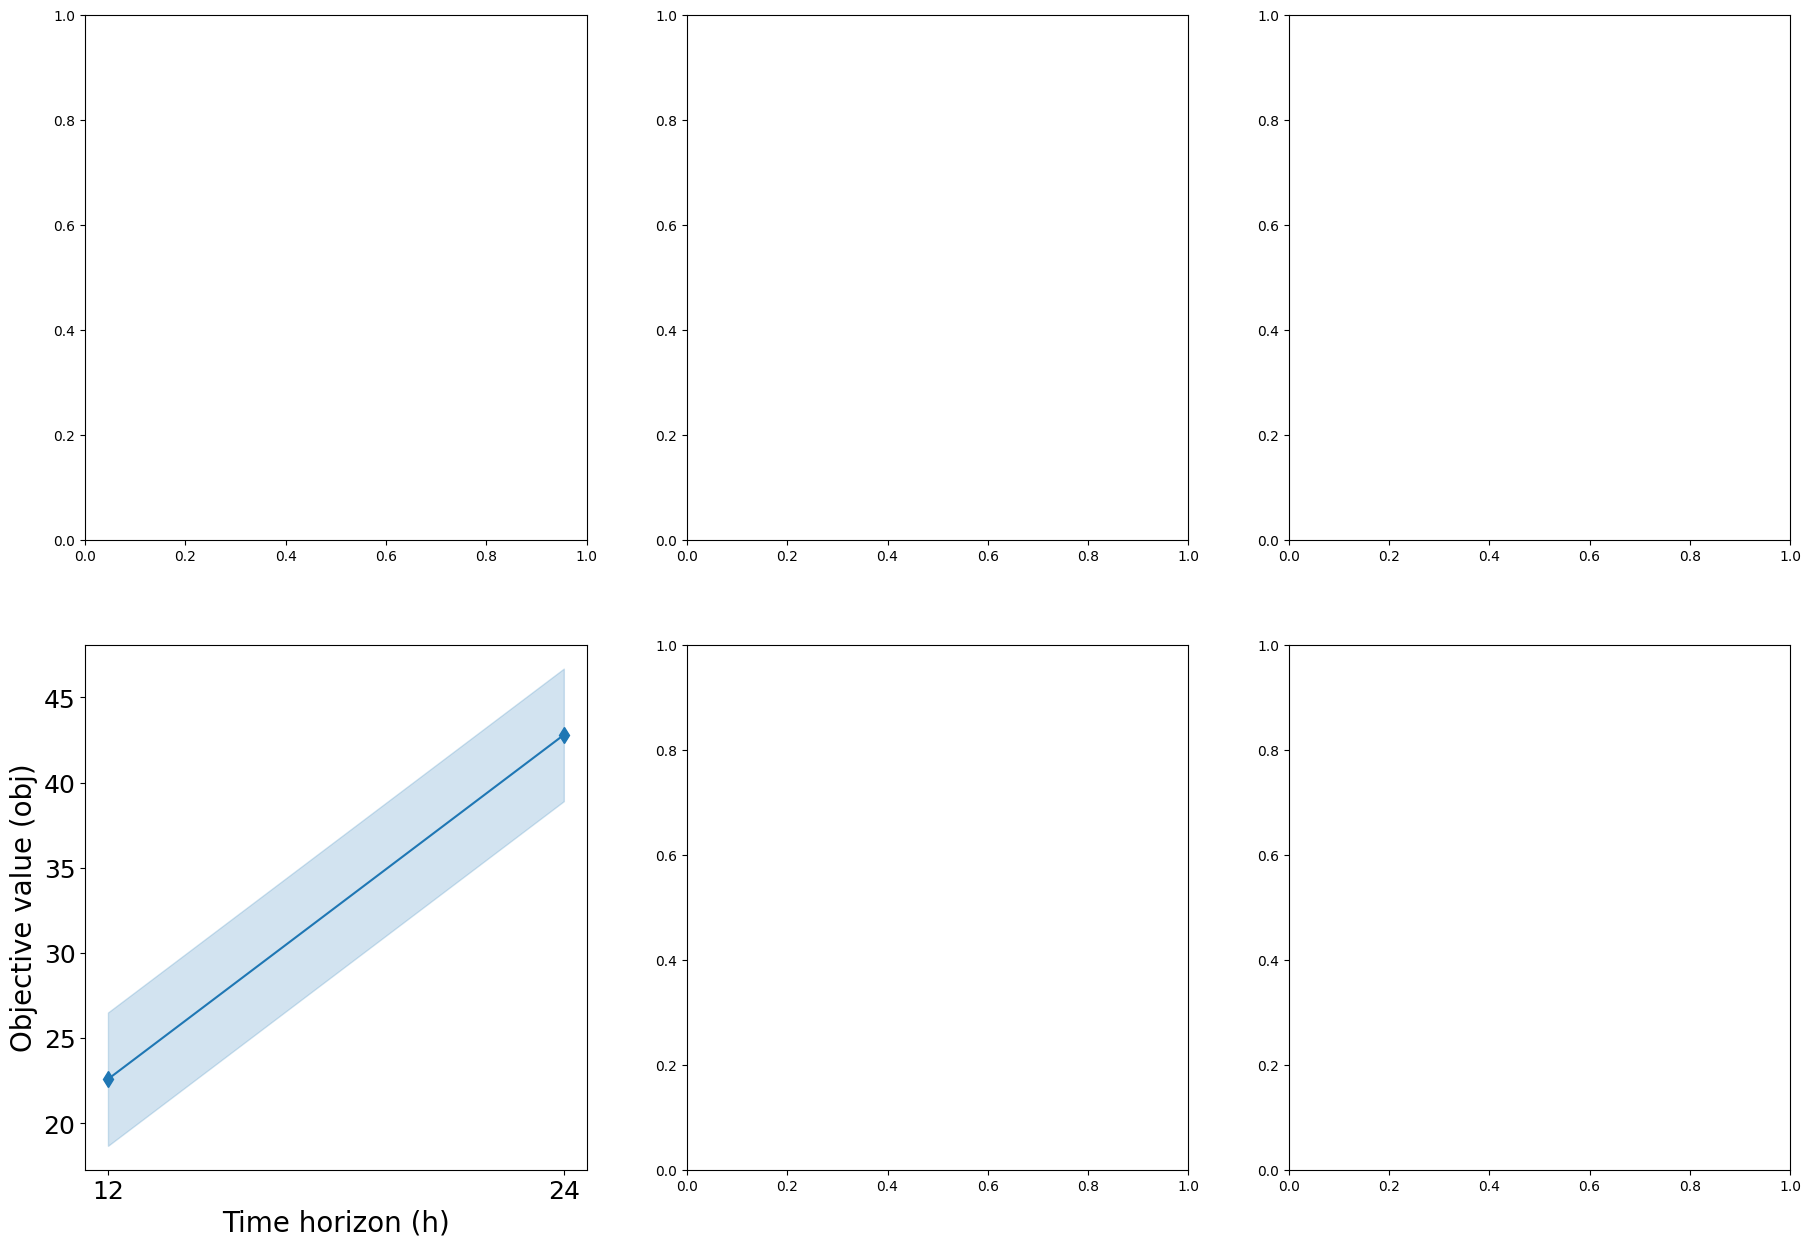

In [ ]:
fig = plt.figure(figsize=(22, 15))
ax_timehorizon = {"time": fig.add_subplot(2, 3, 1), "obj": fig.add_subplot(2, 3, 4)}
ax_ncustms       = {"time": fig.add_subplot(2, 3, 2), "obj": fig.add_subplot(2, 3, 5)}
ax_nevs        = {"time": fig.add_subplot(2, 3, 3), "obj": fig.add_subplot(2, 3, 6)}

#------------------
# for time horizon
#------------------
def get_time_horizon_fname(model_name, time_horizon_):
    return f"results/test_time_horizon/{model_name}_time_horizon{time_horizon_}" + "/summary.json"
timehorizon_res = plot_scale_gen_res(eval_model_list, ax_timehorizon, time_horizon_list, get_time_horizon_fname, xlabel="Time horizon (h)", ylabel_scale="Calculation time (s)", ylabel_gen="Objective value (obj)")
ax_timehorizon["time"].legend(fontsize=12)
ax_timehorizon["obj"].legend(fontsize=12)

#---------------
# for num nodes
#---------------
def get_ncustms_fname(model_name, num_custms_):
    return f"results/test_num_custms/{model_name}_num_custms{num_custms_}" + "/summary.json"
ncustms_res = plot_scale_gen_res(eval_model_list, ax_ncustms, num_custm_list, get_ncustms_fname, xlabel="# base stations")

#-------------
# for num evs
#-------------
def get_nevs_fname(model_name, num_evs_):
    return f"results/test_num_evs/{model_name}_num_evs{num_evs_}" + "/summary.json"
nevs_res = plot_scale_gen_res(eval_model_list, ax_nevs, num_ev_list, get_nevs_fname, xlabel="# EVs")